In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import linprog
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [9]:
os.chdir(r"C:\Users\jakes\OneDrive\Documents\staffing-forecast-optimization\data")
os.getcwd()

'C:\\Users\\jakes\\OneDrive\\Documents\\staffing-forecast-optimization\\data'

In [11]:
df_hourly = pd.read_csv("hour.csv")
print(df_hourly.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


In [35]:
# Creating datetime column, sorting by time, setting datetime index, keeping only target variabe

df_hourly = df_hourly.reset_index(drop=True)
df_hourly["datetime"] = pd.to_datetime(df_hourly["dteday"]) +  pd.to_timedelta(df_hourly["hr"], unit = "h")
df_hourly = df_hourly.sort_values("datetime")
df_hourly = df_hourly.set_index("datetime")
ts = df_hourly[["cnt"]].copy()

print(ts.head())
ts.index.is_monotonic_increasing

                     cnt
datetime                
2011-01-01 00:00:00   16
2011-01-01 01:00:00   40
2011-01-01 02:00:00   32
2011-01-01 03:00:00   13
2011-01-01 04:00:00    1


True

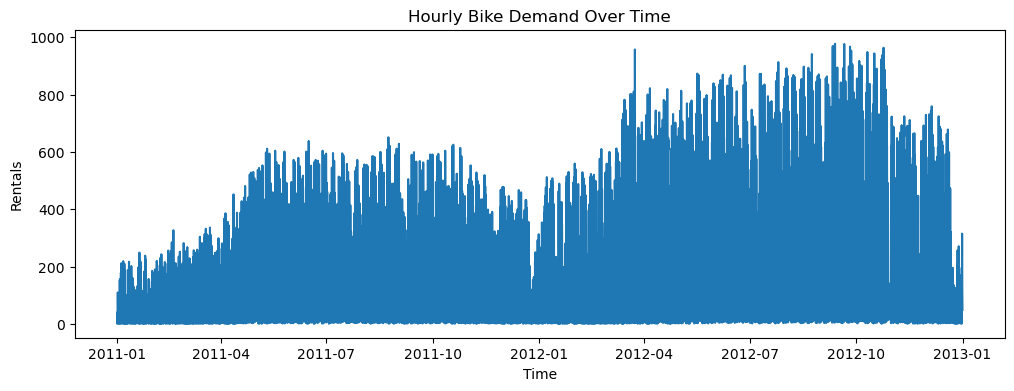

In [37]:
# Plotting full time series

plt.figure(figsize = (12,4))
plt.plot(ts)
plt.title("Hourly Bike Demand Over Time")
plt.xlabel("Time")
plt.ylabel("Rentals")
plt.show()

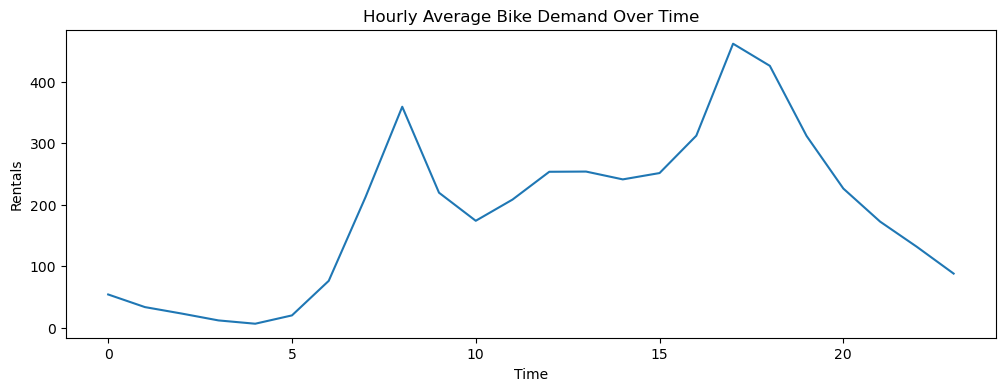

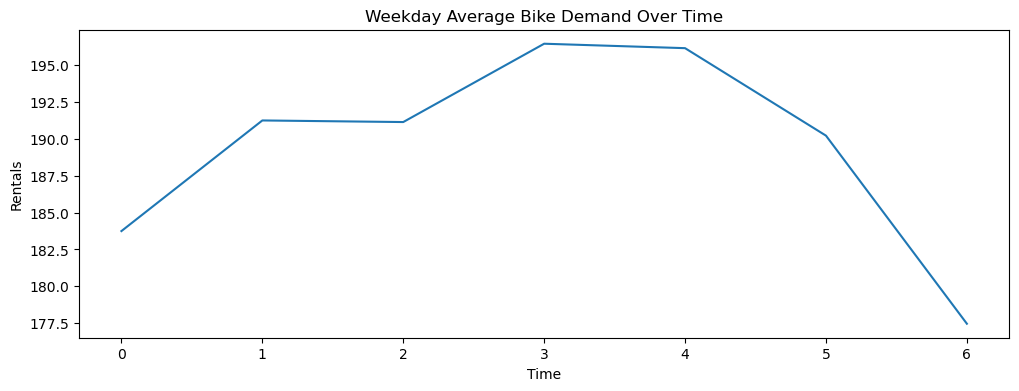

In [43]:
# Subplots (Hour & Day Effects)

ts["hour"] = ts.index.hour
ts["weekday"] = ts.index.weekday

hourly_avg = ts.groupby("hour")["cnt"].mean()
weekday_avg = ts.groupby("weekday")["cnt"].mean()

plt.figure(figsize = (12,4))
plt.plot(hourly_avg)
plt.title("Hourly Average Bike Demand Over Time")
plt.xlabel("Time")
plt.ylabel("Rentals")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(weekday_avg)
plt.title("Weekday Average Bike Demand Over Time")
plt.xlabel("Time")
plt.ylabel("Rentals")
plt.show()

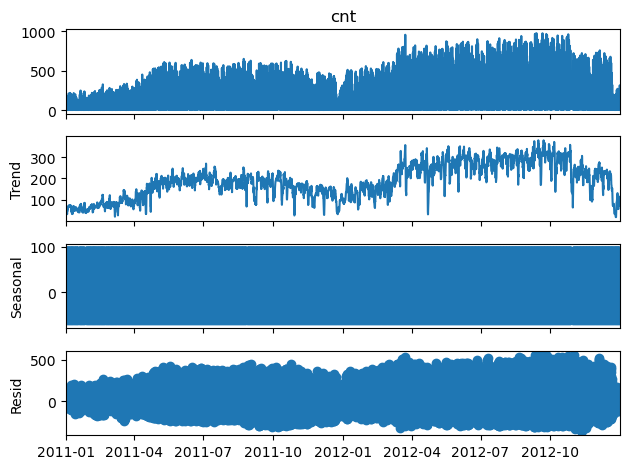

In [47]:
# Decomposition (Demand = Trend + Seasonality + Noise)

decomp = seasonal_decompose(
    ts["cnt"],
    model = "additive",
    period = 24
)
decomp.plot()
plt.show()

Interpreting Results so far: 
<br>
When plotting full time series plot you can see that the general trend of the model is that it is increasing over time meaning that the number of bikes being rented is increasing. However you can see seasonal dips within the model when its a colder season you can see a decrease within the number of rentals.
<br> <br>
As you can see within hourly bike demand over time plot the busy travel hours ie. (7-9am, 5-7 pm) the demand is the highest and then within the weekday demand over time the main days where demand is most popular is within the middle of the week and then lowest on sundays.
<br><br>
When the decomposition was preformed on the demand data, the demand was seperated into components (Trend, Seasonality, Noise). What you can see within daily seasonality is that it is very strong. There is also a relativly smooth long term trend curve and the residuals look relativly random.

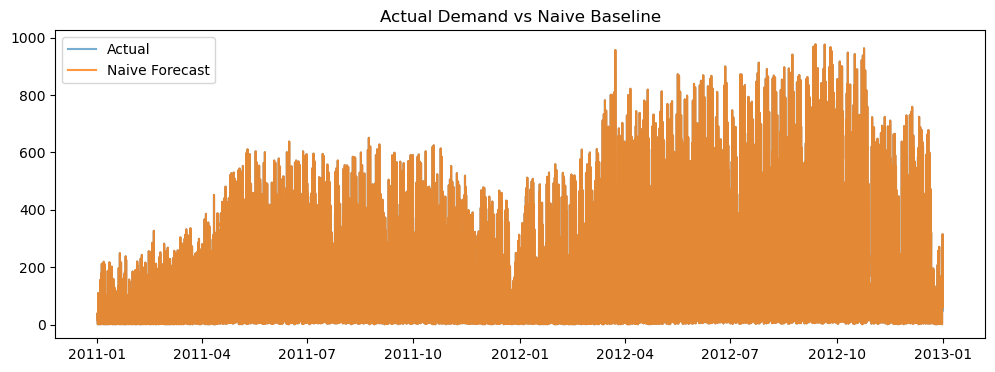

In [68]:
# Baseline Forecasts (Naive Baseline)

# Naive Baseline
ts["naive_forecast"] = ts["cnt"].shift(1)
plt.figure(figsize=(12,4))
plt.plot(ts["cnt"], label = "Actual", alpha =0.6)
plt.plot(ts["naive_forecast"], label = "Naive Forecast", alpha = 0.8)
plt.legend()
plt.title("Actual Demand vs Naive Baseline")
plt.show()


In [82]:
# Evaluating Naive Baseline

y_true = ts["cnt"]
y_pred = ts["hourly_avg_forecast"]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae: .3f}")
print(f"RMSE: {rmse:.3f}")

MAE:  88.100
RMSE: 128.065


In [88]:
# Feautre Engineering (creating time-based features for forecasting)

ts["hour"] = ts.index.hour
ts["day_of_week"] = ts.index.dayofweek
ts["month"] = ts.index.month
ts["is_weekend"] = ts["day_of_week"].isin([0,6]).astype(int)

In [104]:
# Spliting into training and testing data

train = ts.iloc[:-24*7] # all but last week
test = ts.iloc[-24*7:] # last week

In [102]:
# Hourly + Weekday Average Forecast

hour_weekday_means = ts.groupby(["day_of_week", "hour"])["cnt"].mean()
ts["hw_forecast"] = ts.apply(lambda row : hour_weekday_means.loc[(row["day_of_week"], row["hour"])], axis = 1)


Hourly + Weekday Forecast - MAE:  116.836, RMSE:  163.427


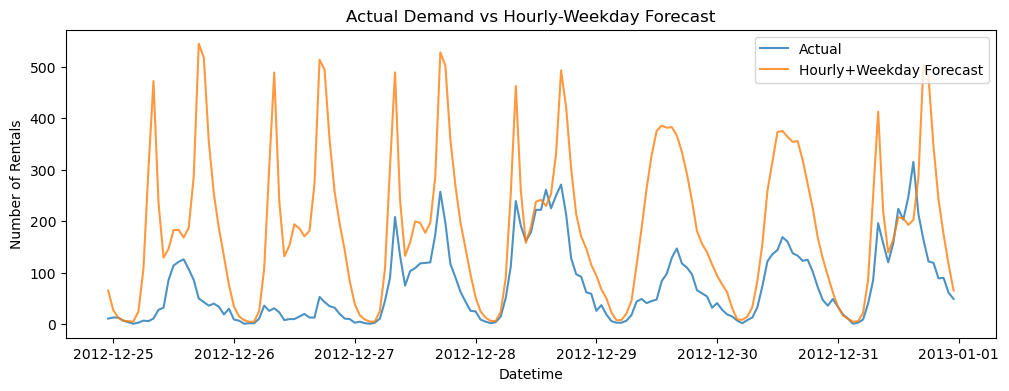

In [106]:
# Evaluating Forecast & Visualization

y_true = test["cnt"]
y_pred = test["hw_forecast"]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Hourly + Weekday Forecast - MAE: {mae: .3f}, RMSE: {rmse: .3f}")

plt.figure(figsize = (12,4))
plt.plot(test["cnt"], label = "Actual", alpha = 0.8)
plt.plot(test["hw_forecast"], label = "Hourly+Weekday Forecast", alpha = 0.8)
plt.xlabel("Datetime")
plt.ylabel("Number of Rentals")
plt.title("Actual Demand vs Hourly-Weekday Forecast")
plt.legend()
plt.show()

Shown in this plot above is the navie model for demand the orange shows our forecast and the blue shows the actual values with both the MAE and RMSE shown above the plot 
<br>
<br>
Tomorrow more advanced time series models will be experimented on such as exponential smoothing and ARIMA: Holi